In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

In [2]:
def r_adjusted(r_squared, X, y):
    return 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

# Initial Inspection

In [3]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [4]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [6]:
'''
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [8]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [9]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [10]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [11]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [12]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


# Looking for outliers

In [15]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [16]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [17]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

#### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [18]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [19]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

## Modelling whole data set

In [20]:
columns_to_drop = ['id', 'date']

In [21]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [22]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement,blt_or_renov,price_per_sqft
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340,5650,0,0,1955.0,188.050847
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,1991.0,98125,47.7210,-122.319,1690,7639,1,1,1991.0,209.338521
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720,8062,0,0,1933.0,233.766234
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360,5000,0,1,1965.0,308.163265
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800,7503,0,0,1987.0,303.571429


# Standardize the data

In [24]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_living_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_living_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['sqft_living15']
sqft_living15_min = min(b)
sqft_living15_range = max(b)-min(b)
df['sqft_living15'] = (b-sqft_living15_min)/sqft_living15_range

b = df['sqft_lot15']
sqft_lot15_min = min(b)
sqft_lot15_range = max(b)-min(b)
df['sqft_lot15'] = (b-sqft_lot15_min)/sqft_lot15_range

b = df['sqft_basement']
sqft_basement_min = min(b)
sqft_basement_range = max(b)-min(b)
df['sqft_basement'] = (b-sqft_basement_min)/sqft_basement_range

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

b = df['yr_renovated']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_renovated'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [25]:
zip_dummy = pd.get_dummies(df["zipcode"], prefix="ZIP")
df = df.drop(columns=["zipcode"],)
df = pd.concat([df, zip_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [26]:
wf_dummy = pd.get_dummies(df["waterfront"], prefix="WF")
df = df.drop(columns=["waterfront"],)
df = pd.concat([df, wf_dummy], axis=1)

In [27]:
view_dummy = pd.get_dummies(df["view"], prefix="VIEW")
df = df.drop(columns=["view"],)
df = pd.concat([df, view_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [28]:
condition_dummy = pd.get_dummies(df["condition"], prefix="COND")
df = df.drop(columns=["condition"],)
df = pd.concat([df, condition_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [29]:
grade_dummy = pd.get_dummies(df["grade"], prefix="GRADE")
df = df.drop(columns=["grade"],)
df = pd.concat([df, grade_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [30]:
print_NAs(df)

Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


In [31]:
df.drop("yr_renovated", axis=1, inplace=True)

In [33]:
#Lets select our predictor data frame
X = df.drop(columns=['price', "price_per_sqft"])

In [34]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [35]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=.5)
linreg.fit(X_train, y_train)
#model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()
#model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
linreg.score(X_train, y_train)

0.8802807076599196

In [37]:
r_squared = linreg.score(X_train, y_train)

adj = r_adjusted(r_squared, X, y)

In [38]:
adj

0.8797013578668262

In [39]:
from sklearn.metrics import r2_score
y_predict = linreg.predict(X_test)

/Users/physics/anaconda/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


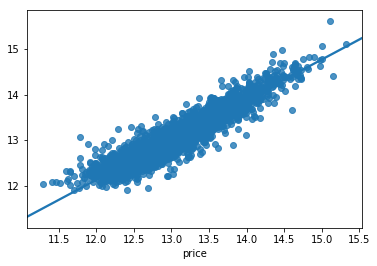

In [40]:
sns.regplot(y_test, y_predict)

In [41]:
r2_score(y_predict, y_test)

0.8589318540577108

In [42]:
y_predict_train = linreg.predict(X_train)
print(r2_score(y_predict_train, y_train))
print(r2_score(y_predict, y_test))

0.8635910675222145
0.8589318540577108


In [43]:
y_predict_train = linreg.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03326977471687509
Test Mean Squarred Error: 0.03416285027737898
1.0268434507929176


In [44]:
model_results = []
model_results.append(["Ridge - alpha .5", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [45]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
lasso.score(X_train, y_train)

0.009518332321658218

In [47]:
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.27525306323432797
Test Mean Squarred Error: 0.03416285027737898
0.12411433273785412


In [48]:
lasso = Lasso(alpha=.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
lasso.score(X_train, y_train)

0.8482165350106045

In [50]:
r2_score(y_predict, y_test)

0.8589318540577108

In [51]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [52]:
alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)

In [56]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

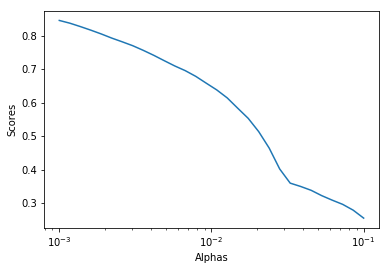

In [57]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [58]:
lasso = Lasso(alpha=.0001)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

0.8787986185283209

In [59]:
from sklearn.metrics import mean_squared_error
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03368164460480046
Test Mean Squarred Error: 0.03416285027737898
1.0142868817192476


In [60]:
adj = r_adjusted(lasso.score(X_train, y_train), X_train, y_train)
model_results.append(["Lasso - alpha .0001", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [61]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/physics/anaconda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [62]:

alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [63]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

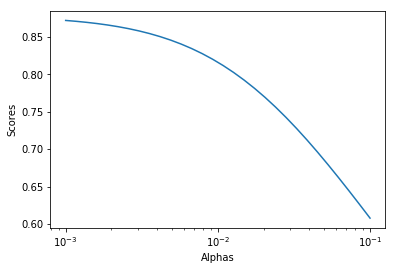

In [64]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [65]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [66]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033516295615664854
Test Mean Squarred Error: 0.03416285027737898
1.0192907554321708


In [67]:
elastic.score(X_train, y_train)

0.8793936169656992

In [68]:
L1_ratios = np.linspace(0, 1, 3)

tuned_parameters = [{'l1_ratio': L1_ratios}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [69]:
clf.fit(X_train, y_train)

/Users/physics/anaconda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/physics/anaconda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/physics/anaconda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'l1_ratio': array([0. , 0.5, 1. ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

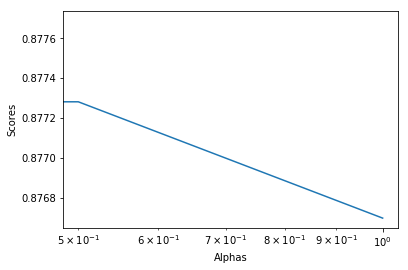

In [70]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(L1_ratios, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [71]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/physics/anaconda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [72]:
elastic.score(X_train, y_train)

0.8798319563598024

In [73]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03339448189119078
Test Mean Squarred Error: 0.03416285027737898
1.0230088428588824


In [74]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="neg_mean_squared_error")

In [75]:
cvs

array([-0.03243468, -0.03838187, -0.03419271, -0.03568091, -0.03360669,
       -0.03460706, -0.03099353, -0.03645084, -0.03171456, -0.03636653,
       -0.02996863, -0.03820755, -0.03199006, -0.02909536, -0.03242644,
       -0.03840192, -0.03510245, -0.03654677, -0.03394573, -0.03366513])

In [76]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="r2")

In [77]:
cvs

array([0.88813437, 0.8648245 , 0.86602451, 0.87703573, 0.88218383,
       0.87902688, 0.89990129, 0.87085709, 0.88242715, 0.87079708,
       0.89235344, 0.85699495, 0.88771556, 0.88771849, 0.87823874,
       0.85275012, 0.8722634 , 0.85825601, 0.87695643, 0.88553963])

In [78]:
lasso.coef_

array([-5.39494586e-04,  4.06484805e-02,  1.14798505e+00,  7.94792004e-01,
       -2.73885127e-02,  1.12674984e+00,  0.00000000e+00, -1.29472384e-01,
        1.22563471e+00, -3.95847118e-01,  4.82499057e-01,  0.00000000e+00,
        4.77585840e-02,  4.94456455e-02,  1.74146615e-04, -2.41788197e-01,
       -2.46820849e-01, -2.67381752e-01,  4.73477171e-01,  1.13812166e-01,
        9.54731012e-02,  4.22288021e-02,  4.91974370e-02,  3.72429350e-02,
       -3.38104539e-01, -1.99521303e-01, -3.03635157e-01,  0.00000000e+00,
       -3.32475673e-01,  0.00000000e+00,  6.10881105e-02, -3.75197891e-01,
        1.21933055e-01, -2.43921935e-01, -2.68211542e-01, -3.71597073e-01,
        9.17803538e-02, -2.06700857e-01, -6.51648962e-02,  5.75859651e-01,
        2.81167242e-01, -2.00456837e-01,  6.19523604e-02, -3.89901783e-02,
       -3.73103779e-02, -2.79981782e-01, -1.52242071e-01, -2.16274789e-01,
       -9.89433188e-02,  8.19486343e-03, -1.09755700e-01, -2.54734934e-01,
       -8.97153953e-03,  

In [79]:
list(zip(lasso.coef_, X_train.columns))

[(-0.0005394945856655398, 'bedrooms'),
 (0.04064848052118824, 'bathrooms'),
 (1.1479850453607163, 'sqft_living'),
 (0.7947920035965418, 'sqft_lot'),
 (-0.027388512707987728, 'floors'),
 (1.1267498422854996, 'sqft_above'),
 (0.0, 'sqft_basement'),
 (-0.1294723844965353, 'yr_built'),
 (1.2256347120752784, 'lat'),
 (-0.3958471178462016, 'long'),
 (0.4824990571050254, 'sqft_living15'),
 (0.0, 'sqft_lot15'),
 (0.04775858398269262, 'is_renovated'),
 (0.049445645484344936, 'has_basement'),
 (0.00017414661463618092, 'blt_or_renov'),
 (-0.24178819721051212, 'ZIP_98001'),
 (-0.24682084885905523, 'ZIP_98002'),
 (-0.2673817523879684, 'ZIP_98003'),
 (0.47347717112436216, 'ZIP_98004'),
 (0.11381216564301383, 'ZIP_98005'),
 (0.09547310120090227, 'ZIP_98006'),
 (0.04222880210430718, 'ZIP_98007'),
 (0.049197436991680915, 'ZIP_98008'),
 (0.037242934957682106, 'ZIP_98010'),
 (-0.3381045394641175, 'ZIP_98011'),
 (-0.19952130255797604, 'ZIP_98014'),
 (-0.30363515671374536, 'ZIP_98019'),
 (0.0, 'ZIP_98022')

In [175]:
coefs = list(zip(lasso.coef_, X_train.columns))

In [177]:
coefs.sort(key=lambda x : x[0], reverse=True)
coefs

[(1.2256347120752784, 'lat'),
 (1.1479850453607163, 'sqft_living'),
 (1.1267498422854996, 'sqft_above'),
 (0.7947920035965418, 'sqft_lot'),
 (0.575859650724235, 'ZIP_98039'),
 (0.4824990571050254, 'sqft_living15'),
 (0.47347717112436216, 'ZIP_98004'),
 (0.46641565577543853, 'WF_1.0'),
 (0.3123428341889464, 'ZIP_98112'),
 (0.2811672423260198, 'ZIP_98040'),
 (0.23324810609827373, 'ZIP_98109'),
 (0.20934598497771678, 'ZIP_98102'),
 (0.19981034574745724, 'ZIP_98119'),
 (0.17431862311982813, 'ZIP_98105'),
 (0.1618424754312336, 'GRADE_11'),
 (0.14997212532207646, 'GRADE_12'),
 (0.13969546652987797, 'GRADE_10'),
 (0.12193305509335026, 'ZIP_98029'),
 (0.11489294375918617, 'ZIP_98122'),
 (0.11381216564301383, 'ZIP_98005'),
 (0.09547310120090227, 'ZIP_98006'),
 (0.09178035377461106, 'ZIP_98033'),
 (0.08571969689904567, 'GRADE_9'),
 (0.07168428150981926, 'ZIP_98116'),
 (0.06195236043505656, 'ZIP_98045'),
 (0.06108811052549113, 'ZIP_98027'),
 (0.05307515197742298, 'ZIP_98107'),
 (0.049445645484344

In [81]:
coefs = [x for x in coefs if "ZIP" in x[1]]

In [82]:
coefs.sort(key=lambda x: x[0])

In [83]:
coefs

[(-0.4255401638423844, 'ZIP_98168'),
 (-0.40460276234763465, 'ZIP_98155'),
 (-0.375197891262582, 'ZIP_98028'),
 (-0.37159707271223985, 'ZIP_98032'),
 (-0.37039831260469497, 'ZIP_98133'),
 (-0.35110891803918365, 'ZIP_98178'),
 (-0.3381045394641175, 'ZIP_98011'),
 (-0.33508301389248457, 'ZIP_98188'),
 (-0.332475673119107, 'ZIP_98023'),
 (-0.3213350639634432, 'ZIP_98198'),
 (-0.30363515671374536, 'ZIP_98019'),
 (-0.27998178212477426, 'ZIP_98055'),
 (-0.2759309840096597, 'ZIP_98148'),
 (-0.2699099029950779, 'ZIP_98077'),
 (-0.2682115415228891, 'ZIP_98031'),
 (-0.2673817523879684, 'ZIP_98003'),
 (-0.2553075452232555, 'ZIP_98177'),
 (-0.2547349341389874, 'ZIP_98072'),
 (-0.25338932939479253, 'ZIP_98146'),
 (-0.25127915023501474, 'ZIP_98106'),
 (-0.24682084885905523, 'ZIP_98002'),
 (-0.2439219352088623, 'ZIP_98030'),
 (-0.24178819721051212, 'ZIP_98001'),
 (-0.2294745726242739, 'ZIP_98108'),
 (-0.22806877434403128, 'ZIP_98125'),
 (-0.21627478903612002, 'ZIP_98058'),
 (-0.20670085677789074, 'ZI

In [84]:
adj = r_adjusted(elastic.score(X_train, y_train), X_train, y_train)
model_results.append(["Elastic - alpha=.0001, l1_ratio=.00001", elastic.score(X_train, y_train), adj, train_mse, test_mse])

In [86]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03339448189119078
Test Mean Squarred Error: 0.03416285027737898
1.0230088428588824


In [88]:
linreg.score(X_train, y_train)

0.880394930520371

In [94]:
adj = r_adjusted(linreg.score(X_train, y_train), X_train, y_train)
adj

0.879670515679891

In [90]:
model_results.append(["Linear Regression", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [92]:
model_results

[['Ridge - alpha .5',
  0.8802807076599196,
  0.8797013578668262,
  0.03326977471687509,
  0.03416285027737898],
 ['Lasso - alpha .0001',
  0.8787986185283209,
  0.8780645352674127,
  0.03368164460480046,
  0.03416285027737898],
 ['Elastic - alpha=.0001, l1_ratio=.00001',
  0.8798319563598024,
  0.8791041317404686,
  0.03339448189119078,
  0.03416285027737898],
 ['Linear Regression',
  0.880394930520371,
  0.879670515679891,
  0.03339448189119078,
  0.03416285027737898]]

In [93]:
print("Ratio of MSEs")
["%s - %s" % (x[0], x[3]/x[4]) for x in model_results]

Ratio of MSEs


['Ridge - alpha .5 - 0.9738582830983735',
 'Lasso - alpha .0001 - 0.9859143581793832',
 'Elastic - alpha=.0001, l1_ratio=.00001 - 0.9775086569197365',
 'Linear Regression - 0.9775086569197365']

# Model Comparison Plot

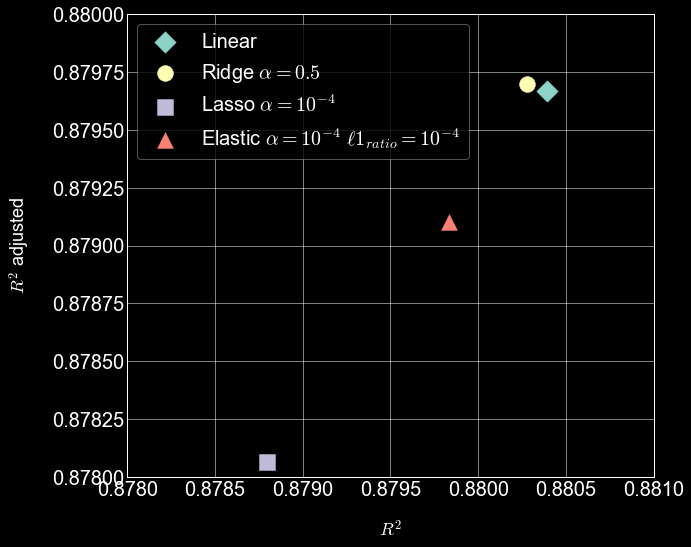

In [172]:
plt.style.use('dark_background')
plt.rc('text',usetex=False)
plt.rcParams.update({'font.size':20})
fig = plt.figure(figsize=(10,8))


x = model_results[3][1]
y = model_results[3][2]
plt.scatter(x,y,marker = 'D', s=230, label = 'Linear')

x = model_results[0][1]
y = model_results[0][2]
plt.scatter(x,y, marker = 'o', s=250, label = r'Ridge $\alpha = 0.5$')

x = model_results[1][1]
y = model_results[1][2]
plt.scatter(x,y,marker = 's',s=250, label = r'Lasso $\alpha = 10^{-4}$')


x = model_results[2][1]
y = model_results[2][2]
plt.scatter(x,y,marker = '^', s=250, label = r'Elastic $\alpha = 10^{-4}$ $\ell1_{ratio}=10^{-4}$')
plt.legend(frameon=True)

plt.xlim([0.878,0.881])
plt.ylim([0.878,0.880])

plt.xlabel(r'$R^{2}$', fontsize=18,labelpad=20)
plt.ylabel(r'$R^{2}$ adjusted', fontsize=18,labelpad=20 )
plt.tight_layout()
plt.savefig('model-comparison.png')

